# 4998 Applied Deep Learning Project
## Detect Cancer Metastases on Pathology Images

Jing Qian (jq2282)

# STEP 1. IMAGE PROCESSING

* Read this paper to understand their approach https://arxiv.org/pdf/1703.02442.pdf
* Start small (use a single slide, at the lowest available zoom level - the effective resolution should be on the order of 1,000 by 1,000 pixels).
* Write code to slide a window across the slide. Extract patches and labels (using the tissue mask).

## 1.1. Import data

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 6s (16.6 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130824 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
# list all the slides provided by professor
!ls '/content/drive/My Drive/project-adl/slides'

tumor_001_mask.tif  tumor_019.tif	tumor_064_mask.tif  tumor_091.tif
tumor_001.tif	    tumor_023_mask.tif	tumor_064.tif	    tumor_094_mask.tif
tumor_002_mask.tif  tumor_023.tif	tumor_075_mask.tif  tumor_094.tif
tumor_002.tif	    tumor_031_mask.tif	tumor_075.tif	    tumor_096_mask.tif
tumor_005_mask.tif  tumor_031.tif	tumor_078_mask.tif  tumor_096.tif
tumor_005.tif	    tumor_035_mask.tif	tumor_078.tif	    tumor_101_mask.tif
tumor_012_mask.tif  tumor_035.tif	tumor_081_mask.tif  tumor_101.tif
tumor_012.tif	    tumor_057_mask.tif	tumor_081.tif	    tumor_110_mask.tif
tumor_016_mask.tif  tumor_057.tif	tumor_084_mask.tif  tumor_110.tif
tumor_016.tif	    tumor_059_mask.tif	tumor_084.tif
tumor_019_mask.tif  tumor_059.tif	tumor_091_mask.tif


从上面可以看到完整的图像有21个，tumor_038和tumor_099有问题，不用。如果是全部都用于train/test，就17个train, 4个test。从1 vs 1开始

In [0]:
slides_list = ['001','002','005','012','016','019','023','031','035','057','059',
              '064','075','078','081','084','091','094','096','101','110']

## 1.2. Generate images of all slides at level 7

Read WSI from /content/drive/My Drive/project-adl/slides/tumor_001.tif includes 10 levels
Read WSI from /content/drive/My Drive/project-adl/slides/tumor_002.tif includes 10 levels
Read WSI from /content/drive/My Drive/project-adl/slides/tumor_005.tif includes 10 levels
Read WSI from /content/drive/My Drive/project-adl/slides/tumor_012.tif includes 10 levels
Read WSI from /content/drive/My Drive/project-adl/slides/tumor_016.tif includes 10 levels
Read WSI from /content/drive/My Drive/project-adl/slides/tumor_019.tif includes 10 levels
Read WSI from /content/drive/My Drive/project-adl/slides/tumor_023.tif includes 10 levels
Read WSI from /content/drive/My Drive/project-adl/slides/tumor_031.tif includes 10 levels
Read WSI from /content/drive/My Drive/project-adl/slides/tumor_035.tif includes 10 levels
Read WSI from /content/drive/My Drive/project-adl/slides/tumor_057.tif includes 10 levels
Read WSI from /content/drive/My Drive/project-adl/slides/tumor_059.tif includes 10 levels
Read WSI f

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


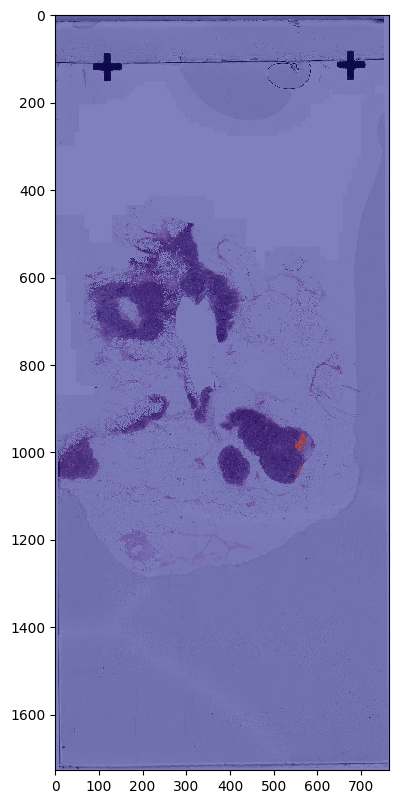

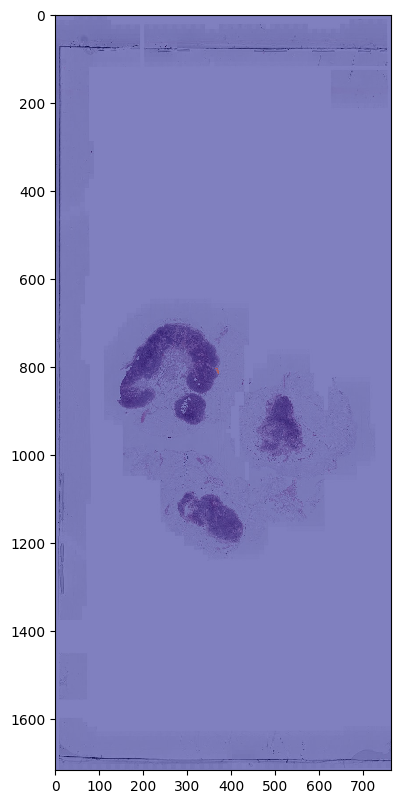

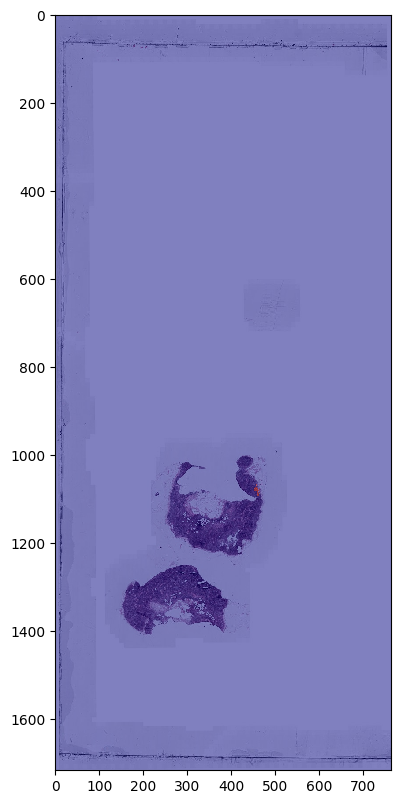

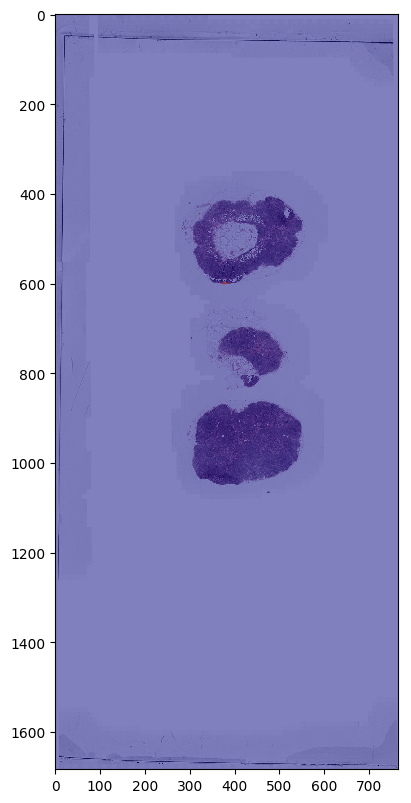

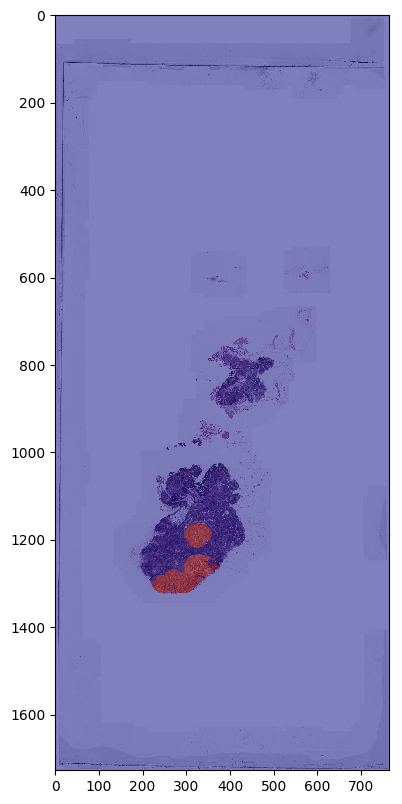

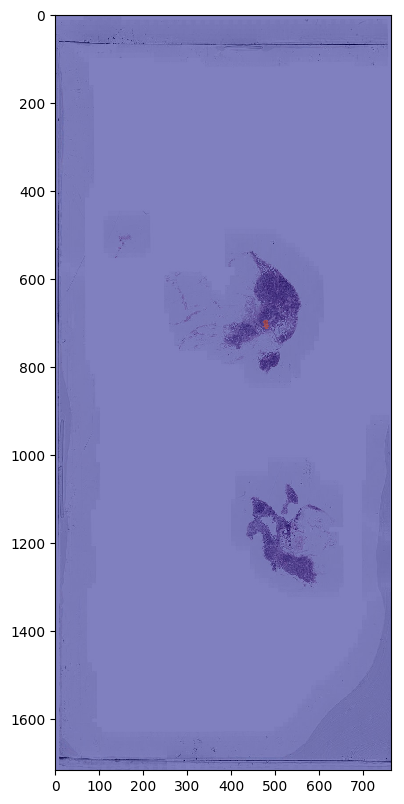

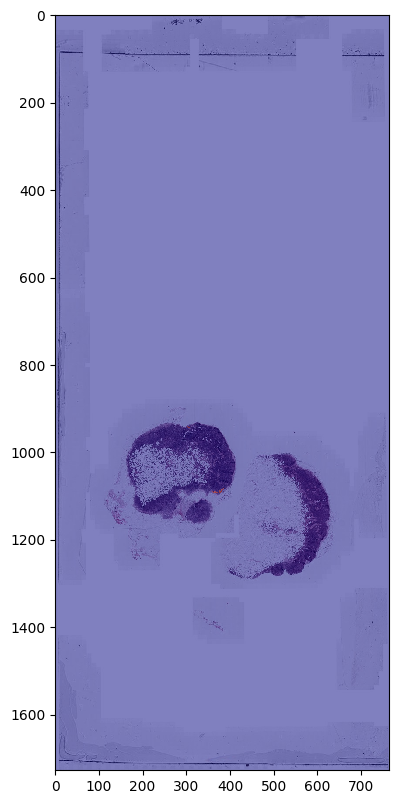

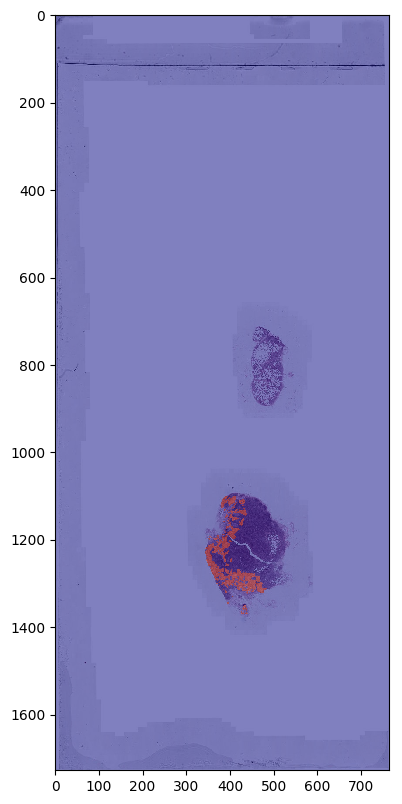

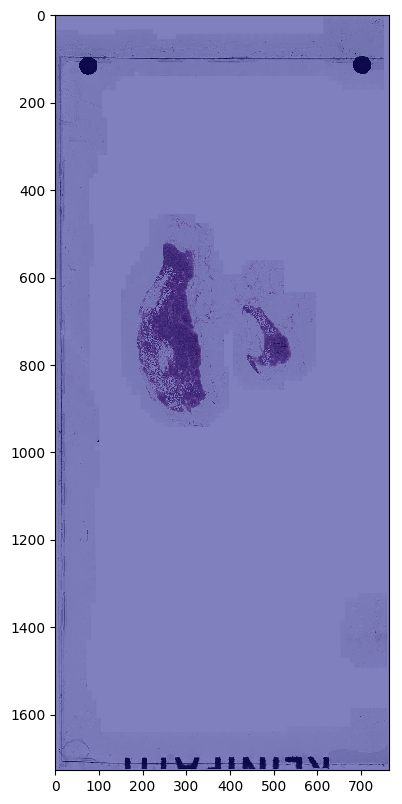

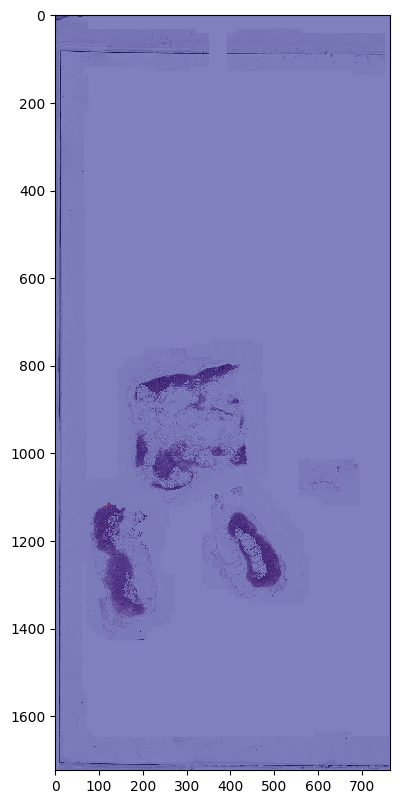

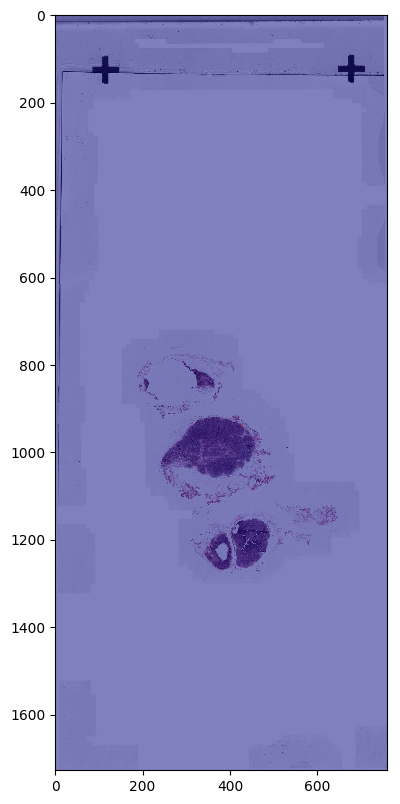

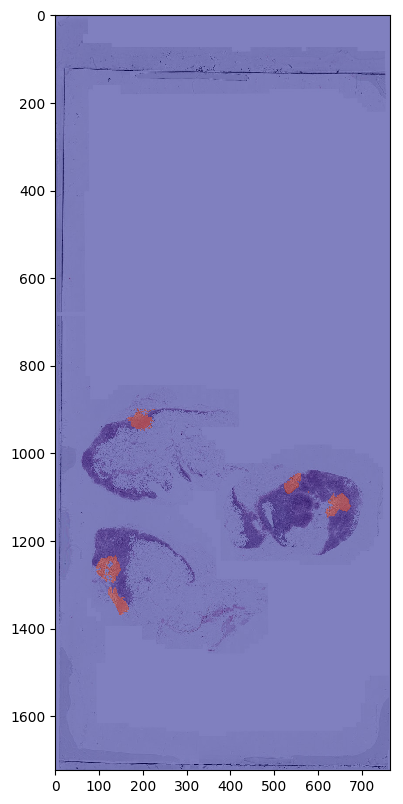

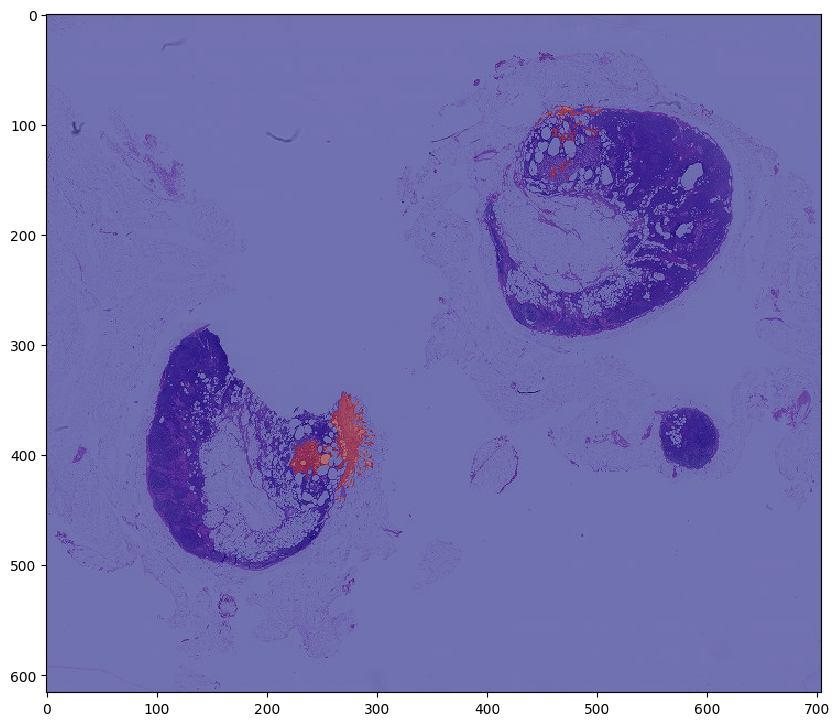

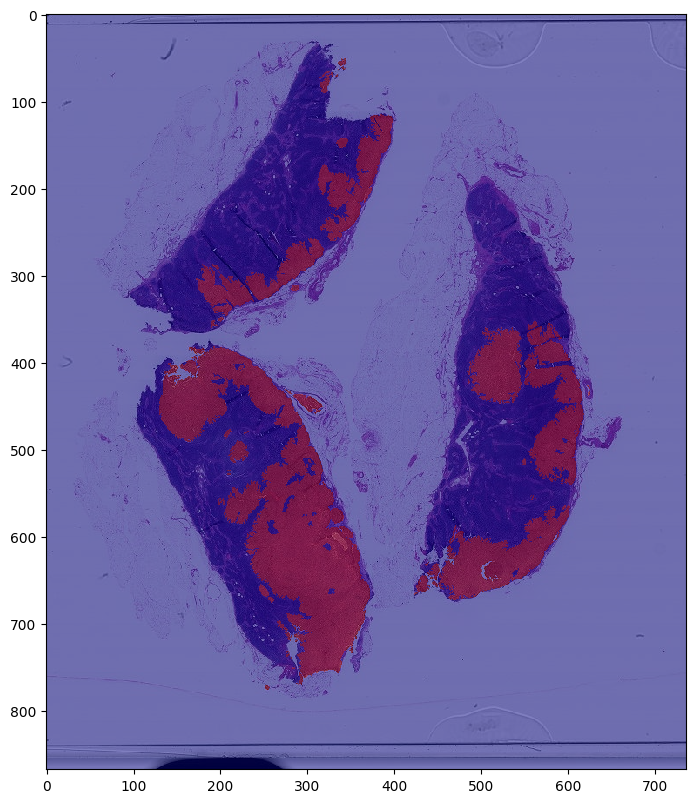

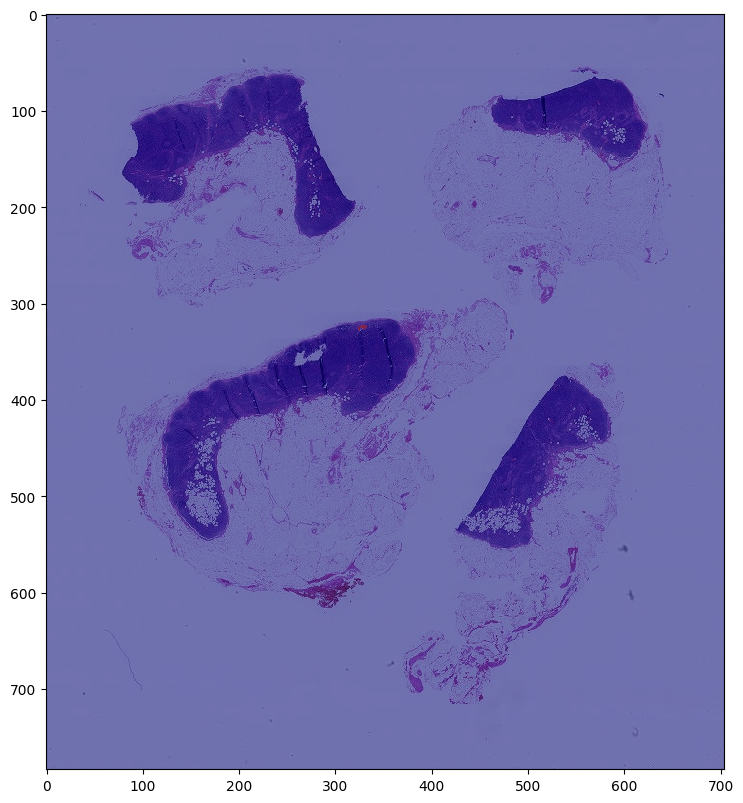

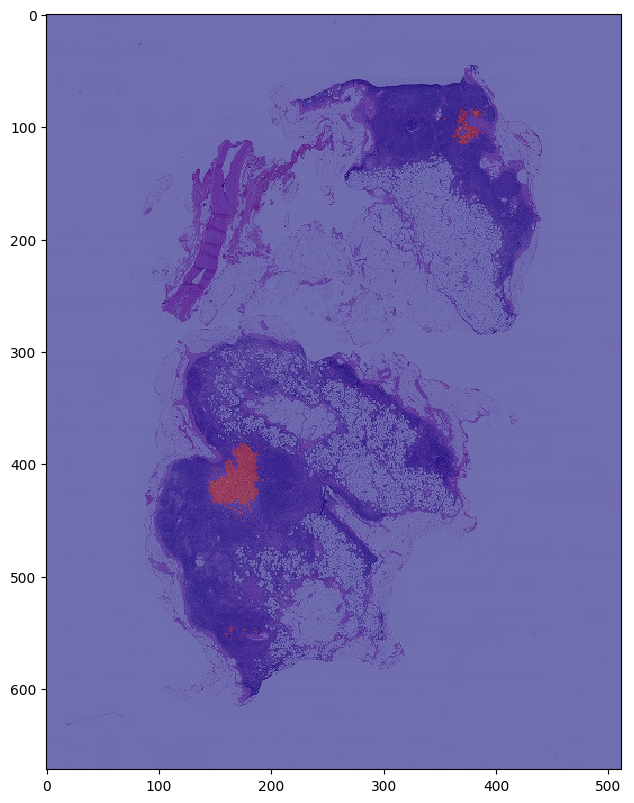

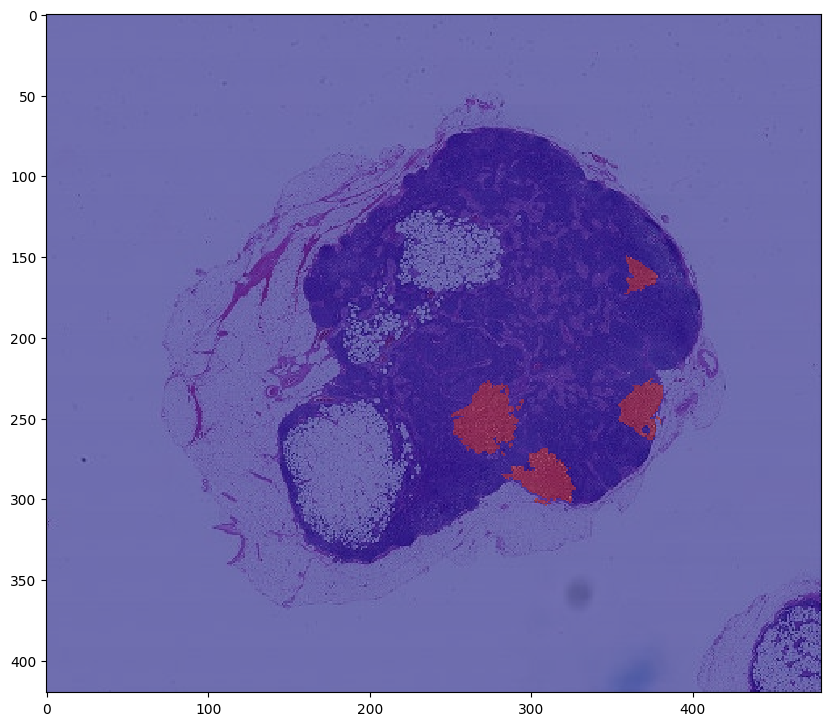

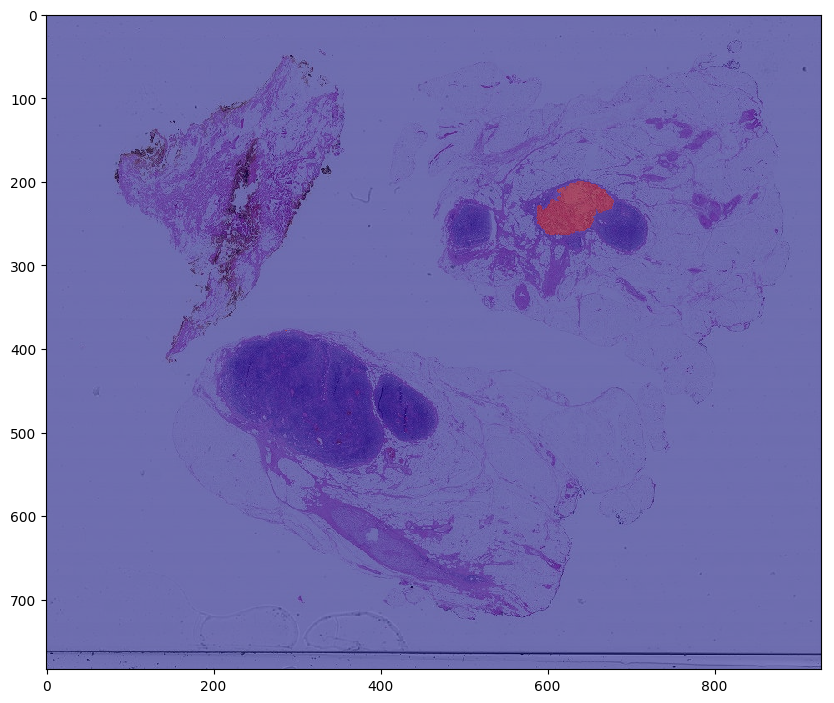

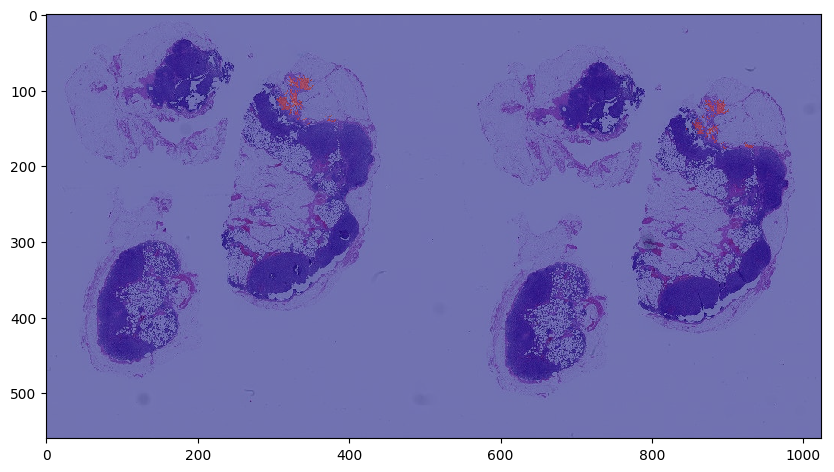

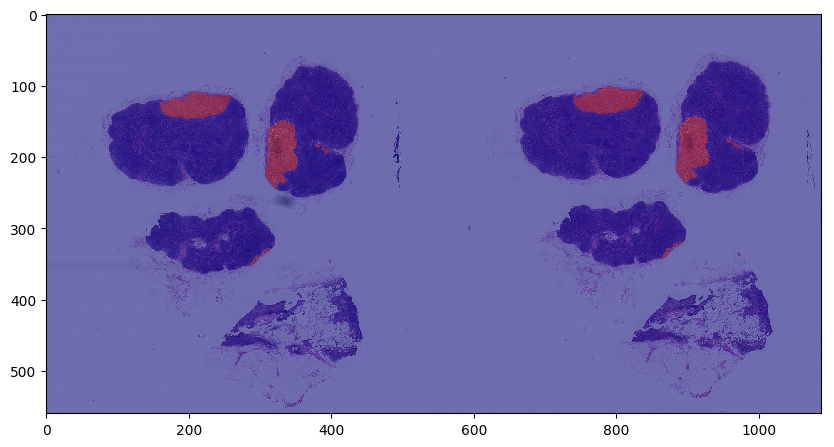

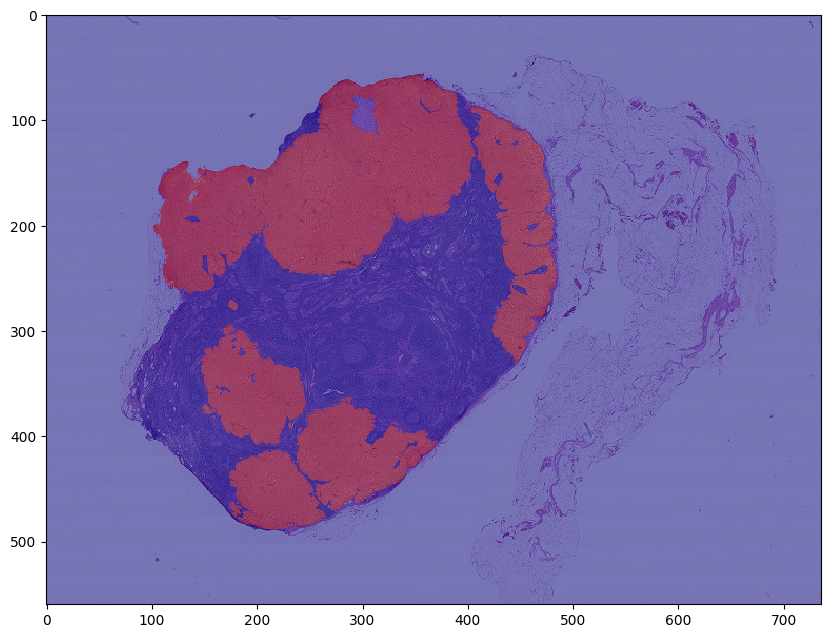

In [24]:
#slide_id='091'
for slide_id in slides_list:
  slide_path = os.path.join(total_path,'tumor_%s.tif' %slide_id)
  tumor_mask_path = os.path.join(total_path,'tumor_%s_mask.tif' %slide_id)

  slide = open_slide(slide_path)
  print("Read WSI from %s includes %d levels" %(slide_path,len(slide.level_dimensions)))
  tumor_mask = open_slide(tumor_mask_path)
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=7, 
                         width=slide.level_dimensions[7][0], 
                         height=slide.level_dimensions[7][1])
  mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=slide.level_dimensions[7][0], 
                        height=slide.level_dimensions[7][1])[:,:,0]
  fig = plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  filename = 'drive/My Drive/project-adl/image_lev7/image_lev7_%s.png' %slide_id
  plt.imshow(mask_image, cmap='jet', alpha=0.5) 
  fig.savefig(filename)
  

## 1.3. Generate training patches and corresponding labels

Sample from only center 10%-90% region to avoid boundary effect.

### Start with one slide

###  General Params

In [0]:
input_size = 299
tumor_check_size = 128
bound = (input_size - 1)/2

In [54]:
down_factor = dict()
for i in range(8):
  down_factor[i] = 2**i
print(down_factor)

{0: 1, 1: 2, 2: 4, 3: 8, 4: 16, 5: 32, 6: 64, 7: 128}


In [0]:
total_path = '/content/drive/My Drive/project-adl/slides'

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    #print('1')
    im = slide.read_region((x,y), level, (width, height))
    #print('2')
    im = im.convert('RGB') # drop the alpha channel
    #print('3')
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

# This function has nothing to do with tumor mask, but shows tissue region
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [0]:
def generate_train(slide_id, nclass, ilevel=4, tissue_intensity=0.5):
  slide_path = os.path.join(total_path,'tumor_%s.tif' %slide_id)
  tumor_mask_path = os.path.join(total_path,'tumor_%s_mask.tif' %slide_id)

  slide = open_slide(slide_path)
  print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

  tumor_mask = open_slide(tumor_mask_path)
  print ("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels", len(slide.level_dimensions))
  for i in range(len(slide.level_dimensions)):
      print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))
      if i < 8:
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

  # Higher zoom levels may not fit into memory.
  # You can use the below function to extract regions from higher zoom levels 
  # without having to read the entire image into ram.

  # Use the sliding window approach discussed in class to collect training
  # data for your classifier. E.g., slide a window across the slide (for
  # starters, use a zoomed out view, so you're not working with giant images).
  # Save each window to disk as an image. To find the label for that image, 
  # check to the tissue mask to see if the same region contains cancerous cells.

  # Important: this is tricky to get right. Carefully debug your pipeline before
  # training your model. Start with just a single image, and a relatively 
  # low zoom level.

  # choose level >=2, or overflow for image reading.
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=ilevel, 
                         width=slide.level_dimensions[ilevel][0], 
                         height=slide.level_dimensions[ilevel][1])
  
  # Keep only tissue regions
  tissue_pixels = list(find_tissue_pixels(slide_image, intensity=tissue_intensity))
  #print('Dimension of Tissue_pixels:', np.shape(tissue_pixels))
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
  
  train_0, train_1 = [], []
  while len(train_0) < nclass or len(train_1) < nclass:
    # Random sample a tissue pixel and generate a patch centered in this pixel
    width = slide.level_dimensions[ilevel][0]
    height = slide.level_dimensions[ilevel][1]
    while True:
      center = tissue_pixels[np.random.choice(np.shape(tissue_pixels)[0])]
      if center[0] > height*0.1 and center[0] < height*0.9:
        if center[1] > width*0.1 and center[1] < width*0.9:
          break
    print(center)

    # Expand a 299*299 patch around the center tissue
    ipatch = read_slide(slide, 
                       x=int(center[0]-bound)*down_factor[ilevel], #16 for level=4 
                       y=int(center[1]-bound)*down_factor[ilevel], 
                       level=ilevel, 
                       width=input_size, 
                       height=input_size)

    # Check whether the 128*128 center pixels have tumor
    ipixels = read_slide(tumor_mask,
                         x = center[0]*down_factor[ilevel]-tumor_check_size//2, #need to change 16 for other levels
                         y = center[1]*down_factor[ilevel]-tumor_check_size//2,
                         level = ilevel,
                         width = tumor_check_size,
                         height = tumor_check_size)[:,:,0]
    #plt.imshow(ipixels)

    ilabel = 0
    if np.any(ipixels) == 1:
      ilabel = 1
    print('The label for the patch is:', str(ilabel))
    if ilabel == 0:
      if len(train_0) < nclass:
        train_0.append(ipatch)
        print('train_0 add one patch and current have %d patches!' %len(train_0))
    else:
      if len(train_1) < nclass:
        train_1.append(ipatch)
        print('train_1 add one patch and current have %d patches!' %len(train_1))
        
  return train_0, train_1

In [69]:
## Test the boundary of defined tissue region and found boundary effects
# xmin, xmax, ymin, ymax = 0, 0, 0, 0
# for i in tissue_pixels:
#   xmin = min(i[0], xmin) 
#   xmax = max(i[0], xmax)#x correspond to dimention[1]
#   ymin = min(i[1], ymin)
#   ymax = max(i[1], ymax)

# print(xmin, xmax, ymin, ymax)
# print('canvas size:', slide.level_dimensions[ilevel])

0 3359 0 3839
canvas size: (3840, 3360)


From above, we could see that for figure, x-axis is horizontal with width while y-axis is vertical with height.
However, the tissue_pixels is organized as following: the 0-element is the row from top to bottom, 1-element is the column from left to right, so 0-element is actually y coordinate and 1-element is actually x coordinate.

I constrain the center of patch as tissue pixel with y > 0.1height and < 0.9height, x > 0.1width and <0.9width.

In [0]:
slide_id = '???'
train_0, train_1 = generate_train(slide_id, 100, ilevel=4, tissue_intensity=0.5)

## 1.4 Save training patches and images

In [0]:
import shutil
train_dir = 'drive/My Drive/project-adl/train_level%d' %ilevel
if not os.path.exists(train_dir):
  os.mkdir(train_dir)
train_0_dir = os.path.join(train_dir, 'patches0')
train_1_dir = os.path.join(train_dir, 'patches1')
if not os.path.exists(train_0_dir):
  os.mkdir(train_0_dir)
if not os.path.exists(train_1_dir):
  os.mkdir(train_1_dir)

In [79]:
slide_id

'084'

(100, 299, 299, 3)


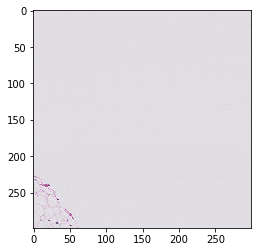

In [80]:
print(np.shape(train_1))
#plt.figure(figsize=(10,10),dpi=100)
plt.imshow(train_0[5])
from matplotlib.image import imsave
for i in range(len(train_0)):
  filename = os.path.join(train_0_dir,'tumor_%s_%d.png' %(slide_id, i))
  imsave(filename,train_0[i])
  
for i in range(len(train_1)):
  filename = os.path.join(train_1_dir,'tumor_%s_%d.png' %(slide_id, i))
  imsave(filename,train_1[i])

# Test 023
决定不用了，肿瘤太少了。以后再说

In [115]:
# slide_id='023'
# slide_path = os.path.join(total_path,'tumor_%s.tif' %slide_id)
# tumor_mask_path = os.path.join(total_path,'tumor_%s_mask.tif' %slide_id)

# slide = open_slide(slide_path)
# print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
#                                                         slide.level_dimensions[0][0], 
#                                                         slide.level_dimensions[0][1]))

# tumor_mask = open_slide(tumor_mask_path)
# print ("Read tumor mask from %s" % (tumor_mask_path))

# print("Slide includes %d levels", len(slide.level_dimensions))
# for i in range(len(slide.level_dimensions)):
#     print("Level %d, dimensions: %s downsample factor %d" % (i, 
#                                                              slide.level_dimensions[i], 
#                                                              slide.level_downsamples[i]))
#     if i < 8:
#       assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
#       assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# # Verify downsampling works as expected
# width, height = slide.level_dimensions[7]
# assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
# assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/drive/My Drive/project-adl/slides/tumor_023.tif with width: 97792, height: 221184
Read tumor mask from /content/drive/My Drive/project-adl/slides/tumor_023_mask.tif
Slide includes %d levels 10
Level 0, dimensions: (97792, 221184) downsample factor 1
Level 1, dimensions: (48896, 110592) downsample factor 2
Level 2, dimensions: (24448, 55296) downsample factor 4
Level 3, dimensions: (12224, 27648) downsample factor 8
Level 4, dimensions: (6112, 13824) downsample factor 16
Level 5, dimensions: (3056, 6912) downsample factor 32
Level 6, dimensions: (1528, 3456) downsample factor 64
Level 7, dimensions: (764, 1728) downsample factor 128
Level 8, dimensions: (382, 864) downsample factor 256
Level 9, dimensions: (191, 432) downsample factor 512


In [0]:
# ipixels = read_slide(tumor_mask,
#                          x = 0, #need to change 16 for other levels
#                          y = 0,
#                          level = 7,
#                          width = slide.level_dimensions[7][0],
#                          height = slide.level_dimensions[7][1])[:,:,0]
# plt.figure(figsize=[10,10],dpi=100)
# plt.imshow(ipixels)

In [0]:
# train_dir = 'drive/My Drive/project-adl/test'
# if not os.path.exists(train_dir):
#   os.mkdir(train_dir)
# for i in range(len(train_0)):
#   filename = os.path.join(train_dir,'tumor_%s_%d.png' %(slide_id, i))
#   imsave(filename,train_0[i])

# test all black

In [0]:
# center_list = []
# train_0=[]
# while len(train_0) < nclass:
#     # Random sample a tissue pixel and generate a patch centered in this pixel
#     width = slide.level_dimensions[ilevel][0]
#     height = slide.level_dimensions[ilevel][1]
#     while True:
#       center = tissue_pixels[np.random.choice(np.shape(tissue_pixels)[0])]
#       if center[0] > height*0.1 and center[0] < height*0.9:
#         if center[1] > width*0.1 and center[1] < width*0.9:
#           break
#     print(center)
#     center_list.append(center)

#     # Expand a 299*299 patch around the center tissue
#     ipatch = read_slide(slide, 
#                        x=int(center[0]-bound)*down_factor[ilevel], #16 for level=4 
#                        y=int(center[1]-bound)*down_factor[ilevel], 
#                        level=ilevel, 
#                        width=input_size, 
#                        height=input_size)

#     # Check whether the 128*128 center pixels have tumor
#     ipixels = read_slide(tumor_mask,
#                          x = center[0]*down_factor[ilevel]-tumor_check_size//2, #need to change 16 for other levels
#                          y = center[1]*down_factor[ilevel]-tumor_check_size//2,
#                          level = ilevel,
#                          width = tumor_check_size,
#                          height = tumor_check_size)[:,:,0]
#     #plt.imshow(ipixels)

#     ilabel = 0
#     if np.any(ipixels) == 1:
#       ilabel = 1
#     print('The label for the patch is:', str(ilabel))
#     if ilabel == 0:
#       if len(train_0) < nclass:
#         train_0.append(ipatch)
#         print('train_0 add one patch and current have %d patches!' %len(train_0))

In [0]:
# for i in range(len(train_0)):
#   filename = os.path.join(train_0_dir,'tumor_%s_%d.png' %(slide_id, i))
#   imsave(filename,train_0[i])

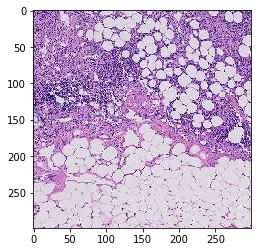

In [101]:
# plt.imshow(np.array(train_0[24],dtype=np.uint8))

In [123]:
# train_0[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

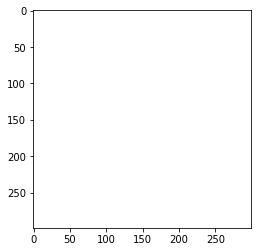

In [126]:
# plt.imshow(np.uint8(train_0[0]))